In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
import math
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

# Object to impute missing values in dataframe
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

# object to encode categorial variables
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# function that returns dict of classification metrics
def model_stats(x,y):
    accuracy = "%.2f" % (accuracy_score(y, x))
    precision = "%.2f" % (precision_score(y, x))
    recall = "%.2f" % (recall_score(y, x))
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}

# function that plots roc curve
def roc_plot(x, y, label, cr, ls, lw):
    fpr, tpr, _ = roc_curve(y, x)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (AUC = {:0.2f})'.format(label, roc_auc),
         color=cr, linestyle=ls, linewidth=lw)

In [2]:
'''
Data used is available here: https://www.lendingclub.com/info/download-data.action
Can download locally or run the following code:

import requests, zipfile, io

for i in ['a', 'b', 'c']:
    r = requests.get("https://resources.lendingclub.com/LoanStats3"+i+".csv.zip", stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

'''
loans1 = pd.read_csv('../LoanStats3a.csv', skiprows=1)
loans2 = pd.read_csv("../LoanStats3b.csv", skiprows=1)
loans3 = pd.read_csv("../LoanStats3c.csv", skiprows=1)

# merging
loans = loans1.append(loans2)
loans = loans.append(loans3)

# drop null columns
loans = loans.dropna(axis=1, how='all')

# drop mostly null columns
good_columns = []
for column in loans.columns:
    if (loans[column].isnull()).value_counts()[True]/loans[column].size < 0.1:
        good_columns.append(column)
        
loans = loans[good_columns]

# fill in missing data with mean
loans = DataFrameImputer().fit_transform(loans)

# clean up some columns
loans["term"] = loans["term"].astype(str)
loans["term"] = loans['term'].apply(lambda x: x.split(' ')[1])
loans["term"] = loans["term"].astype(int)
loans["year"] = loans["issue_d"].apply(lambda x: x.split("-")[1])
loans["int_rate"] = loans["int_rate"].apply(lambda x: float(x.split("%")[0]))

In [3]:
'''
Features below selected using LASSO on a larger feature list
lasso = LogisticRegression(C = 0.002, penalty='l1')
lasso.fit(xScaled,y)

Number of Attributes: 21
In-Sample Accuracy: 84.13 %
The coefficient values of LASSO-MODEL are: 
                               Value
Intercept                  -1.858940
term                        0.215284
installment                 0.043333
annual_inc                 -0.149365
dti                         0.123484
delinq_2yrs                 0.012622
inq_last_6mths              0.061505
open_acc                    0.064265
pub_rec                     0.011039
revol_bal                  -0.040058
total_acc                  -0.028300
collections_12_mths_ex_med  0.002408
pub_rec_bankruptcies        0.013127
int_rate                    0.126151
sub_grade                   0.304593
emp_title                   0.071515
emp_length                  0.003319
home_ownership              0.103310
title                       0.013610
initial_list_status         0.011643
last_credit_pull_d          0.573350
revol_util                  0.022085

'''

numerical = ['term', 
             'installment', 
             'annual_inc', 
             'dti', 
             'inq_last_6mths', 
             'open_acc', 
             'pub_rec', 
             'revol_bal', 
             'total_acc',  
             'collections_12_mths_ex_med',
             'pub_rec_bankruptcies', 'int_rate'] 

categorical = ['sub_grade', 
               'emp_title', 
               'emp_length',
               'home_ownership', 
               'title',
               'initial_list_status', 
               'last_credit_pull_d',
               'revol_util']

# encode categorial variables
categorical_columns = MultiColumnLabelEncoder(columns = categorical).fit_transform(loans[categorical])
loans_final = pd.concat([loans[numerical],categorical_columns],axis=1)

# define bad loans
bad_categories = ['Charged Off',
       'Does not meet the credit policy. Status:Charged Off', 
       'In Grace Period', 'Late (31-120 days)', 'Late (16-30 days)',
       'Default']

loans["bad"] = loans["loan_status"].apply(lambda x: 1 if x in bad_categories else 0)

# set dependent variable to y and independent variable frame to xScaled
y = loans['bad'].astype(int)
X = loans_final
xScaled = StandardScaler().fit_transform(X)

# create training and test sets
x_train, x_test, y_train, y_test = train_test_split(xScaled, y, train_size=0.8)

In [9]:
# summary stats for the entire data set
summary = pd.DataFrame(index = list(loans["year"].unique()), 
                       columns=["Count", "Bad", "Avg Rate", "Modal Term", "Avg Amount"])

for year in list(summary.index):
    yloans = loans[loans["year"]==year]
    summary["Count"][year] = yloans["year"].count()
    summary["Bad"][year] = yloans["bad"].sum()
    summary["Avg Rate"][year] = yloans["int_rate"].mean()
    summary["Modal Term"][year] = int(yloans["term"].mode())
    summary["Avg Amount"][year] = yloans["loan_amnt"].mean()

summary.sort_index(inplace=True)
summary.style.set_table_attributes('class="pure-table"')

,Count,Bad,Avg Rate,Modal Term,Avg Amount
2007,603,158,11.8251,36,8254.52
2008,2393,496,12.062,36,8825.43
2009,5281,723,12.4372,36,9833.03
2010,12537,1757,11.9853,36,10528.2
2011,21721,3297,12.2234,36,12047.5
2012,53367,8644,13.6378,36,13461.7
2013,134814,21053,14.532,36,14707.4
2014,235636,40598,13.7695,36,14870.1


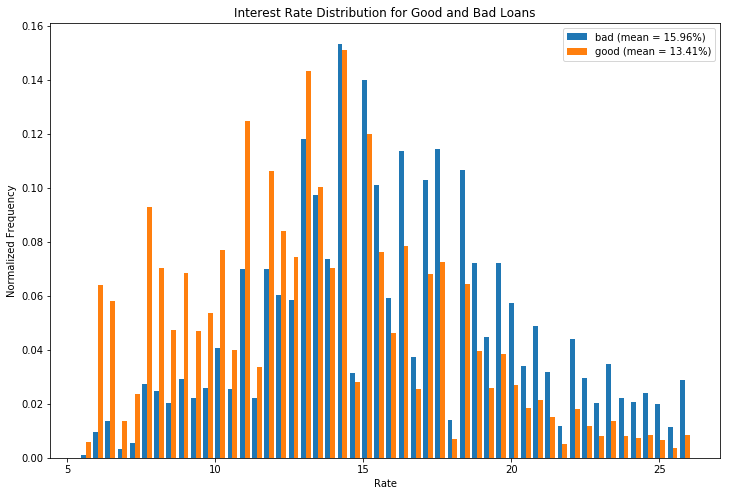

In [6]:
plt.figure(figsize=(12,8))
bins = 50
bad = loans[loans["bad"]==1]["int_rate"]
good = loans[loans["bad"]==0]["int_rate"]
plt.hist([bad, good], bins, 
         label=['bad (mean = {0:0.2f}%)'.format(bad.mean()),
                'good (mean = {0:0.2f}%)'.format(good.mean())], density=True)
plt.legend(loc='upper right')
plt.xlabel('Rate')
plt.ylabel('Normalized Frequency')
plt.title('Interest Rate Distribution for Good and Bad Loans')
plt.show()

In [7]:
loans["int_rate"].describe()

count    466352.000000
mean         13.828516
std           4.357894
min           5.420000
25%          10.990000
50%          13.660000
75%          16.490000
max          26.060000
Name: int_rate, dtype: float64

In [10]:
# summary stats for the validation set
test_loans = loans.iloc[list(y_test.index)]
summary = pd.DataFrame(index = list(loans["year"].unique()), 
                       columns=["Count", "Bad", "Avg Rate", "Modal Term", "Avg Amount"])

for year in list(summary.index):
    yloans = test_loans[test_loans["year"]==year]
    summary["Count"][year] = yloans["year"].count()
    summary["Bad"][year] = yloans["bad"].sum()
    summary["Avg Rate"][year] = yloans["int_rate"].mean()
    summary["Modal Term"][year] = int(yloans["term"].mode())
    summary["Avg Amount"][year] = yloans["loan_amnt"].mean()

summary.sort_index(inplace=True)
summary.style.set_table_attributes('class="pure-table"')
print("Total loans: ",summary["Count"].sum())
print("Total bad: ",summary["Bad"].sum())
print('Avg Rate: {0:.2f}%'.format(summary["Avg Rate"].mean()))
print("Modal Term: ",int(summary["Modal Term"].mode()))
print('Avg Amount: ${0:.2f}'.format(summary["Avg Amount"].mean()))

Total loans:  93271
Total bad:  14369
Avg Rate: 12.70%
Modal Term:  36
Avg Amount: $11648.09


In [9]:
model_stats(test_loans["int_rate"].apply(lambda x: 1 if x > 16.5 else 0),y_test)

{'Accuracy': '0.67', 'Precision': '0.17', 'Recall': '0.26'}

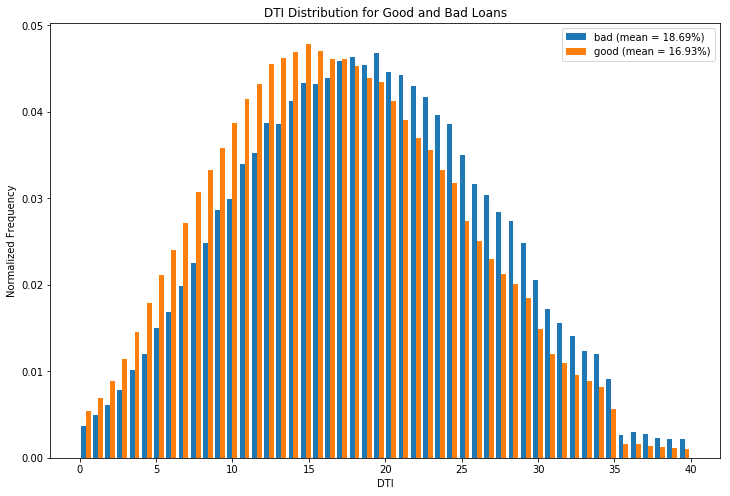

In [10]:
plt.figure(figsize=(12,8))
bins = 50
bad = loans[loans["bad"]==1]["dti"]
good = loans[loans["bad"]==0]["dti"]
plt.hist([bad, good], bins, 
         label=['bad (mean = {0:0.2f}%)'.format(bad.mean()),
                'good (mean = {0:0.2f}%)'.format(good.mean())], density=True)
plt.legend(loc='upper right')
plt.xlabel('DTI')
plt.ylabel('Normalized Frequency')
plt.title('DTI Distribution for Good and Bad Loans')
plt.show()

In [11]:
loans["dti"].describe()

count    466352.000000
mean         17.219336
std           7.851261
min           0.000000
25%          11.360000
50%          16.870000
75%          22.780000
max          39.990000
Name: dti, dtype: float64

In [12]:
model_stats(test_loans["dti"].apply(lambda x: 1 if x > 22.8 else 0),y_test)

{'Accuracy': '0.70', 'Precision': '0.17', 'Recall': '0.21'}

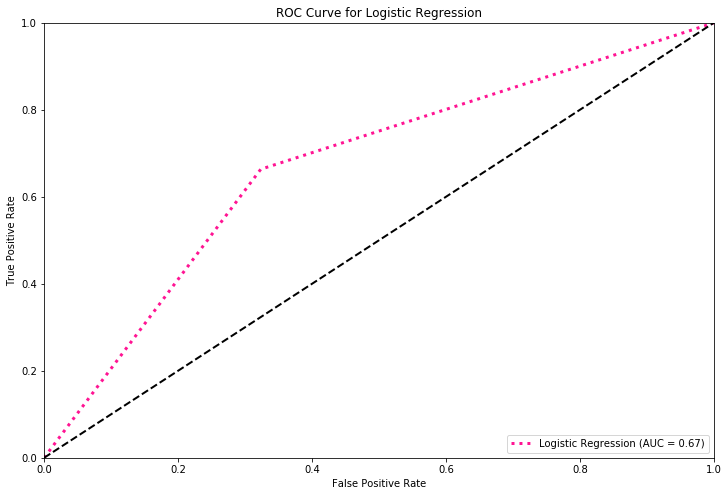

In [11]:
'''
Logistic regression 

'''
logistic_regression = LogisticRegression(class_weight='balanced', random_state=42, penalty='l2', solver="sag")
logistic_regression.fit(x_train,y_train)
plt.figure(figsize=(12,8))
roc_plot(logistic_regression.predict(x_test), y_test, "Logistic Regression", "deeppink", ':', 3)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [14]:
model_stats(logistic_regression.predict(x_test), y_test)

{'Accuracy': '0.67', 'Precision': '0.29', 'Recall': '0.66'}

In [12]:
'''
Random forest and GBT results saved to file and loaded.  Can download file or train models 
using following code (note: GBT can up to two hours to train)

# Model parameters chosen using GridSearch
rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_estimators=200, max_depth=10,
                               bootstrap=True, criterion='gini', max_features=20, min_samples_leaf=10, 
                                min_samples_split=2, oob_score=True, n_jobs=-1)
rf.fit(x_train,y_train)
filename = 'rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))
'''
random_forest = pickle.load(open("rf_model.sav", 'rb'))
model_stats(random_forest.predict(x_test), y_test)

{'Accuracy': '0.84', 'Precision': '0.51', 'Recall': '0.69'}

In [13]:
'''
# Model parameters chosen using GridSearch
gbt = GradientBoostingClassifier(n_estimators=200, max_depth=10, random_state=42, verbose=2)
gbt.fit(x_train,y_train)
filename = 'gbt_model.sav'
pickle.dump(gbt, open(filename, 'wb'))

'''
gbt = pickle.load(open("gbt_model.sav", 'rb'))
model_stats(gbt.predict(x_test), y_test)

{'Accuracy': '0.92', 'Precision': '0.86', 'Recall': '0.59'}

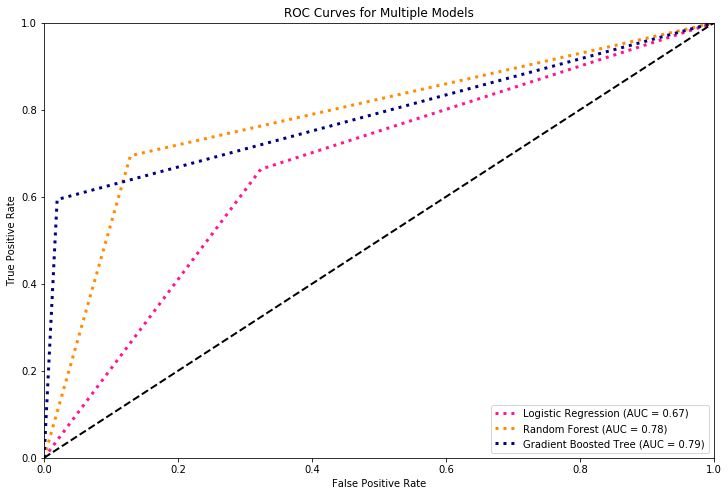

In [14]:
plt.figure(figsize=(12,8))

roc_plot(logistic_regression.predict(x_test), y_test, "Logistic Regression", "deeppink", ':', 3)
roc_plot(random_forest.predict(x_test), y_test, "Random Forest", "darkorange", ':', 3)
roc_plot(gbt.predict(x_test), y_test, "Gradient Boosted Tree", "navy", ':', 3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend(loc="lower right")
plt.show()